In [1]:
# In this notebook, transformer networks is going to be used in time series dataframe


In [14]:
import pandas as pd
import numpy as np

### Reading the data

In [15]:
df = pd.read_csv("/mnt/e/PdM/DataX/MetroPT/Modified_df.csv")
df.head()

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Flowmeter,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,imminent_failure,Failure Component Encoded,Failure Type Encoded
0,2022-01-01 06:00:00,-0.012,9.758,9.760,-0.028,1.576,63.350,19.049625,3.9550,1,0,1,1,0,0,0,0,0,3,1
1,2022-01-01 06:00:01,-0.012,9.760,9.760,-0.028,1.578,63.250,19.049625,4.0275,1,0,1,1,0,0,0,0,0,3,1
2,2022-01-01 06:00:02,-0.010,9.760,9.760,-0.028,1.578,63.325,19.040281,3.9450,1,0,1,1,0,0,0,0,0,3,1
3,2022-01-01 06:00:03,-0.012,9.756,9.756,-0.030,1.576,63.200,19.040281,3.9300,1,0,1,1,0,0,0,0,0,3,1
4,2022-01-01 06:00:04,-0.012,9.756,9.756,-0.030,1.578,63.150,19.049625,3.9950,1,0,1,1,0,0,0,0,0,3,1


In [4]:
df.columns

Index(['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric',
       'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level',
       'Caudal_impulses', 'imminent_failure', 'Failure Component Encoded',
       'Failure Type Encoded'],
      dtype='object')

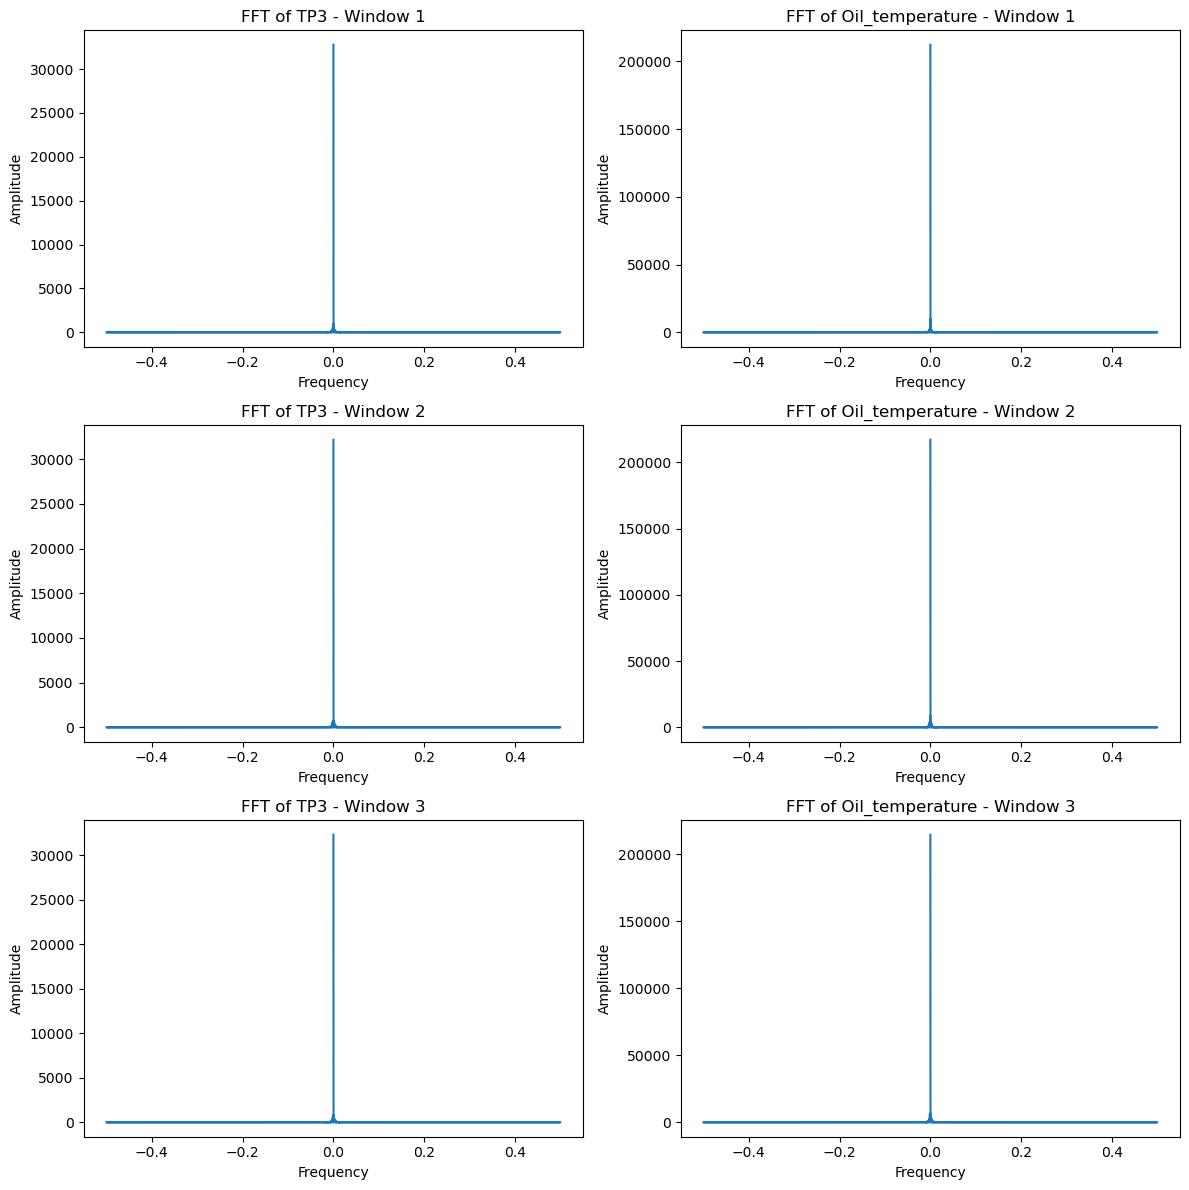

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft

# فرض بر این است که df دیتاست شما است
# df = pd.read_csv('path_to_your_dataset.csv') # برای خواندن داده‌ها از یک فایل

# اصلاح کد برای نمایش نمودارها به صورت 3x2 (برای 3 پنجره و 2 ستون)
def plot_fft_custom_windows(df, columns, window_size, num_windows):
    # اطمینان از اینکه تعداد پنجره‌ها بیشتر از مقدار ممکن نیست
    max_windows = len(df) // window_size
    num_windows = min(num_windows, max_windows)

    # ایجاد نمودارها به صورت ستونی
    fig, axes = plt.subplots(num_windows, len(columns), figsize=(12, 4 * num_windows))

    # برای هر ستون و پنجره
    for j, column in enumerate(columns):
        for i in range(num_windows):
            # بخش‌بندی داده‌ها بر اساس پنجره
            segment = df[column].iloc[i*window_size:(i+1)*window_size].to_numpy()

            # انجام تبدیل فوریه
            fft_result = fft(segment)

            # محاسبه فرکانس‌ها
            freq = np.fft.fftfreq(len(fft_result))

            # رسم نمودار در مکان مربوطه
            ax = axes[i, j] if num_windows > 1 else axes[j]
            ax.plot(freq, np.abs(fft_result))
            ax.set_title(f'FFT of {column} - Window {i+1}')
            ax.set_xlabel('Frequency')
            ax.set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# رسم تبدیل فوریه برای ستون‌های TP3 و Oil_temperature در تعداد مشخصی از پنجره‌ها
plot_fft_custom_windows(df, ['TP3', 'Oil_temperature'], 3600, 3) # تعداد 3 پنجره در نظر گرفته شده است



-

## Time Series FFT with Timestamps

This script performs a Fast Fourier Transform (FFT) on selected columns of time series data within a specified time range and a set number of windforming FFT.

### Function: `plot_fft_with_timestamp`
- **Parameters:** DataFrame (`df`), columns for FFT, window size, number of windows, start and end time.
- **Functionality:** Converts timestamps, filters data, computes FFT in windows, and plots the results.
- **Usage:** Call with a DataFrame including a 'timestamp' column and numerical a in Jupyter Notebook.

In [16]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft

def plot_fft_with_timestamp(df, columns, window_size, num_windows, start_time, end_time):
    # Convert the 'timestamp' column to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Filter the data based on the time range
    df_filtered = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]

    # Calculate the maximum possible number of windows based on the filtered data
    max_windows = len(df_filtered) // window_size
    num_windows = min(num_windows, max_windows)

    # Create subplot layout
    fig, axes = plt.subplots(num_windows, len(columns), figsize=(12, 4 * num_windows))

    # Loop through each column and window
    for j, column in enumerate(columns):
        for i in range(num_windows):
            # Segment the data based on the current window
            segment = df_filtered[column].iloc[i*window_size:(i+1)*window_size].to_numpy()
            time_segment = df_filtered['timestamp'].iloc[i*window_size:(i+1)*window_size]

            # Perform the FFT
            fft_result = fft(segment)

            # Calculate frequencies
            freq = np.fft.fftfreq(len(fft_result))

            # Plotting
            ax = axes[i, j] if num_windows > 1 else axes[j]
            ax.plot(time_segment, np.abs(fft_result))
            ax.set_title(f'FFT of {column} - Window {i+1}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Amplitude')
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    plt.tight_layout()
    plt.show()


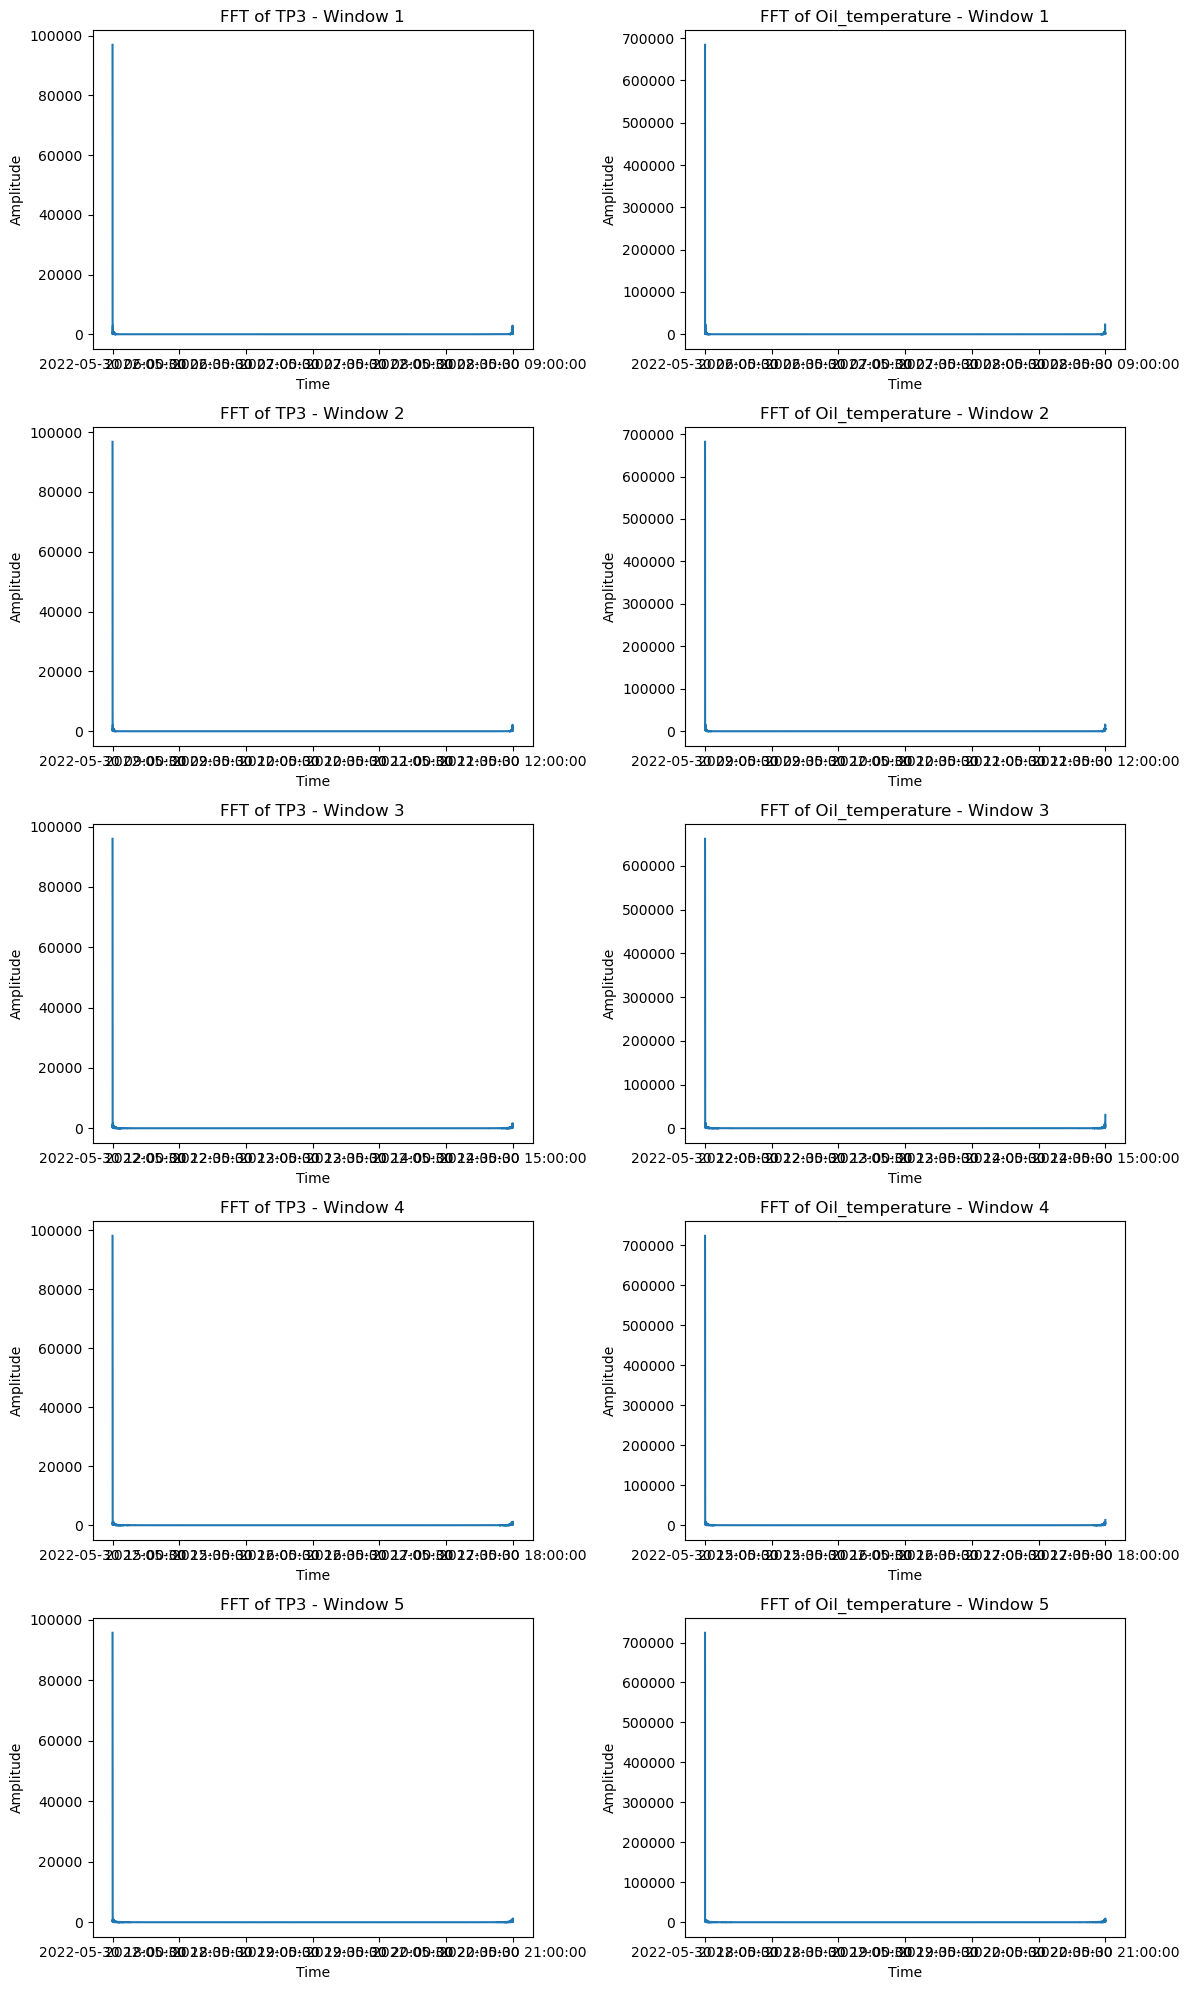

In [17]:
plot_fft_with_timestamp(df, ['TP3', 'Oil_temperature'], 10800, 5, '2022-05-30 06:00:00', '2022-05-31 03:00:00')



## Data Preparation for Fault Prediction Model

In this section, we prepare our dataset for the fault prediction model. Our goal is to predict `imminent_failure` (a binary indicator) using various sensor data. The process involves selecting the relevant features, normalizing certain columns, and splitting the data into features (X) and the target variable (y).

### Step 1: Selecting Columns

We select the following columns as features (X):

- Sensor Data: `TP2`, `TP3`, `H1`, `DV_pressure`, `Reservoirs`, `Oil_temperature`, `Flowmeter`, `Motor_current`
- Additional Features: `COMP`, `DV_eletric`, `Towers`, `MPG`, `LPS`, `Pressure_switch`, `Oil_level`, `Caudal_impulses`

The target variable (y) is:

- `imminent_failure`: Indicates the presence of a fault.

### Step 2: Normalizing Sensor Data

To ensure that our model performs well, we normalize the sensor data columns. Normalization is done using `StandardScaler` from the scikit-learn library, which standardizes features by removing the mean and scaling to unit variance.

The following sensor data columns are normalized:

- `TP2`, `TP3`, `H1`, `DV_pressure`, `Reservoirs`, `Oil_temperature`, `Flownd for others or for your future reference.

In [11]:
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame
# Selecting columns for X and y
X = df[['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Flowmeter', 'Motor_current', 
        'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']]
y = df['imminent_failure']

# Create a copy to avoid SettingWithCopyWarning
X_normalized = X.copy()

# Normalizing specified columns
scaler = StandardScaler()
normalized_columns = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Flowmeter', 'Motor_current']
X_normalized[normalized_columns] = scaler.fit_transform(X[normalized_columns])

# Now X_normalized is normalized and ready to be used in the model


-

## Transformer Model for Fault Prediction

In this section, we build and train a Transformer model to predict `imminent_failure` using our preprocessed dataset. The Transformer model, known for its effectiveness in handling sequential data, is well-suited for time-series sensor data.

### Model Architecture

Our Transformer model consists of the following components:

- **Input Layer**: Takes the preprocessed feature set.
- **Transformer Encoder Blocks**: Multiple layers of transformer encoders, each including:
  - Multi-head attention mechanism.
  - Feed-forward neural network.
  - Layer normalization and dropout for regularization.
- **MLP Head**: A series of dense layers for classification.
- **Output Layer**: A single dense layer with sigmoid activation for binary classification (fault/no fault).

### Configuration and Compilation

The model is configured with the following parameters:
- Number of heads in multi-head attention.
- Dimension of the feed-forward network.
- Number of transformer blocks.
- Dimensionality of the MLP layers.
- Dropout rates for regularization.

### Building the Model

The model is built using TensorFlow and Keras p_units, dropout, mlp_dropout)
```

### Model Summary

A summary of the model is provided to understand its complexity anmeters:

```python
model.summary()
```

### Training the Model

The model is trained using the following parameters:
- Loss function: Binary cross-entropy, suitable for binary classification tasks.
- Optimizer: Adam, a popular choice for deep learning models.
- Metrics: Acding the model's design and training process in your notebook.

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    if len(input_shape) != 3:
        raise ValueError("Expected input_shape to be a tuple of (batch_size, sequence_length, num_features)")

    inputs = Input(shape=input_shape[1:])  # Excluding batch size
    x = inputs

    # Transformer Blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # MLP Head
    x = LayerNormalization(epsilon=1e-6)(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)

    # Output layer
    outputs = Dense(1, activation="sigmoid")(x)

    # Create and compile model
    model = Model(inputs, outputs)
    model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])
    return model


# Model configuration
input_shape = X.shape[1:]  # Shape of input features
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 4
mlp_units = [128, 64]  # Size of the dense layers of the final classifier
dropout = 0.1
mlp_dropout = 0.1

# Build the model
model = build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)

# Summary of the model
model.summary()

# Train the model
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


ValueError: Expected input_shape to be a tuple of (batch_size, sequence_length, num_features)